# Image Segmentation Task 1
#### Welcome to the first task of Image Segmentation. Image segmentation is the process of partitioning the image into a set of pixels representing an object. In this task, you will be introduced to the problem of image segmentation and programming pipeline involved in image segmentation.

For the purpose of this task we will be using PASCAL VOC datset. The dataset contains a total of 2913 images with segmentation annotations. Code in the cell below will download the code and extract the dataset.

In [ ]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
!tar -xvf VOCtrainval_11-May-2012.tar

In [ ]:
!easy_install pip
!pip install pillow>=4.3.0
!pip install scipy==1.1.0

### 1.1 Loading the dataset

In [1]:
import os
import copy
import random
import torch
import imageio
import numpy as np
import torch.optim as optim
from os.path import join as pjoin

# import pascalVOCDataset
from datasets.pascalvoc import pascalVOCDataset

### 1.2 Define the model architecture(2.0 point)
In this section you have the freedom to decide your own model. Keep in mind though, to perform image segmentation, you need to implement an architecture that does pixel level classification i.e. for each pixel in the image you need to predict the probability of it belonging to one of the 21 categories.

In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

In [3]:
class SimpleSegNet(nn.Module):
    """ SimpleSegNet network """
    def __init__(self):
        super(SimpleSegNet, self).__init__()

        self.encoder = models.vgg16(pretrained = True, progress=False).features

        self.conv1 = nn.Conv2d(512, 21, 1)

        self.convtrans = nn.ConvTranspose2d(21, 21, 62, stride = 30)

    def forward(self, x):
        #define the forward pass
        x = self.encoder(x)
        x = self.conv1(x)
        x = self.convtrans(x)
        return x

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"]="6" 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device 

device(type='cuda')

In [5]:
model = SimpleSegNet().to(device)

### 1.3 Hyperparameters(0.5 points)
Define all the hyperparameters(not restricted to the three given below) that you find useful here.

In [6]:
# reproducibility setups
torch.manual_seed(253452757)
random.seed(253452757)
np.random.seed(253452757)

In [7]:
local_path = 'VOCdevkit/VOC2012/' # modify it according to your device
bs = 10
epochs = 30
learning_rate = 0.01
sgd_momentum = 0.9
with_weights = True

### 1.4 Dataset and Dataloader(0.5 points)
Create the dataset using pascalVOCDataset class defined above. Use local_path defined in the cell above as root. 

In [8]:
# dataloader variable
train_data = pascalVOCDataset(local_path, split="train")
train_data_raw = pascalVOCDataset(local_path, split="train", is_transform=False)
val_data = pascalVOCDataset(local_path, split="val")

In [9]:
dataset_sizes = {
    'train' : len(train_data),
    'val': len(val_data),
    'total': len(train_data) + len(val_data)
}

dataloaders = {
    'train' : torch.utils.data.DataLoader(train_data, batch_size=bs, shuffle=True, num_workers=0),
    'val': torch.utils.data.DataLoader(val_data, batch_size=bs, shuffle=True, num_workers=0)
}

In [10]:
dataset_sizes

{'train': 1464, 'val': 1449, 'total': 2913}

### 1.5 Loss fuction and Optimizer(1.0 point)
Define below with the loss function you think would be most suitable for segmentation task. You are free to choose any optimizer to train the network.

In [11]:
from utils import median_frequency_balancing

In [ ]:
# compute the weights of each class to account for the class imbalance 
if with_weights:
    weights = torch.from_numpy(median_frequency_balancing(train_data, 21)).float()
else:
    weights = None

In [ ]:
# loss function
if with_weights:
    loss_f = nn.CrossEntropyLoss(weight=weights.to(device))
else:
    loss_f = nn.CrossEntropyLoss()

# optimizer variable
opt = optim.SGD(model.parameters(), lr=learning_rate, momentum=sgd_momentum)

### 1.6 Training the model(3.0 points)
Your task here is to complete the code below to perform a training loop and save the model weights after each epoch of training.

In [12]:
from utils import plot_metric
from training import train

In [13]:
model_path = "models/task1/w_w/lr001"

if not os.path.isdir(model_path):
    os.makedirs(model_path)

In [ ]:
model = train(model, dataloaders, dataset_sizes, model_path, loss_f, opt, epochs)

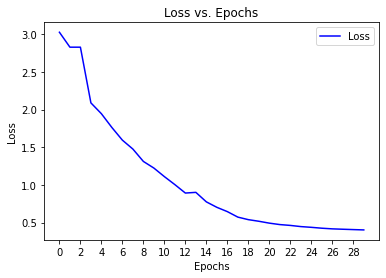

In [14]:
losses = []
for epoch in range(epochs):    
    checkpoint = torch.load(pjoin(model_path, "epoch-{}.pt".format(epoch)))
    losses.append(checkpoint['loss'])
                            
plot_metric(losses, "Loss")

### 1.7 Evaluate your model(1.5 points)
In this section you have to implement the evaluation metrics for your model. Calculate the values of F1-score, dice coefficient and AUC-ROC score on the data you used for training. You can use external packages like scikit-learn to compute above metrics.

In [15]:
from evaluation import EvaluationReport

Since the F1-score and the Dice's coefficient are equivalent, we have included Jaccard's similarity, also denoted as **intersection-over-union (IoU) metric** instead of Dice's coefficient.

In [ ]:
for epoch in range(epochs):
    print('Evaluating Epoch {}/{}'.format(epoch, epochs - 1))
    
    # load model
    checkpoint = torch.load(pjoin(model_path, "epoch-{}.pt".format(epoch)))
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # create evaluation report from model
    eval_report = EvaluationReport.from_model(dataloaders['train'], model,list(range(21)))
    
    # compute the desired metrics
    checkpoint['f1-score'] = eval_report.f1_score(average="macro")
    checkpoint['jaccard-sim'] = eval_report.jaccard_similarity(average="macro")
    
    # save checkpoint with metrics
    torch.save(checkpoint, pjoin(model_path, "epoch-{}.pt".format(epoch)))                      

In [16]:
f1_scores = []
jaccard_similarities = []
roc_auc_scores = []

for epoch in range(epochs):    
    checkpoint = torch.load(pjoin(model_path, "epoch-{}.pt".format(epoch)))
    f1_scores.append(checkpoint['f1-score'])
    jaccard_similarities.append(checkpoint['jaccard-sim'])

### 1.8 Plot the evaluation metrics against epochs(1.0)
In section 1.6 we saved the weights of the model after each epoch. In this section, you have to calculate the evaluation metrics after each epoch of training by loading the weights for each epoch. Once you have calculated the evaluation metrics for each epoch, plot them against the epochs.

In [20]:
from utils import plot_metric

#### F1-score

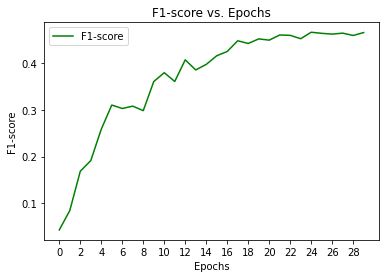

In [21]:
plot_metric(f1_scores, "F1-score", "g")

In [35]:
print("Maximal F1-score = {} (epoch {})".format(max(f1_scores), np.argmax(f1_scores)))

Maximal F1-score = 0.4655 (epoch 24)


#### Jaccard's similarity / mIoU

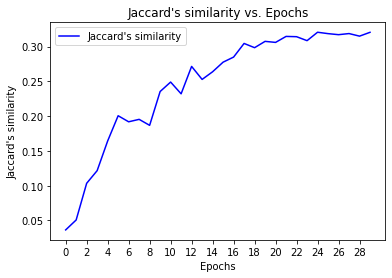

In [22]:
plot_metric(jaccard_similarities, "Jaccard's similarity")

In [37]:
print("Maximal Jaccard's similarity = {} (epoch {})".format(max(jaccard_similarities), np.argmax(jaccard_similarities)))

Maximal Jaccard's similarity = 0.3205 (epoch 24)


#### ROC AUC

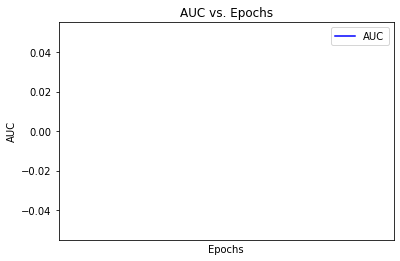

In [23]:
plot_metric(roc_auc_scores, "AUC")

### 1.9 Visualize results(0.5 points)
For any 10 images in the dataset, show the images along the with their segmentation mask.

In [17]:
from utils import plot_seg_results
from torchvision import transforms

Select the best model with respect to its *Jaccard's similarity / mIoU*

In [18]:
best_epoch = np.argmax(jaccard_similarities)
best_epoch

24

Load the best model's weight:

In [19]:
checkpoint = torch.load(pjoin(model_path, "epoch-{}.pt".format(best_epoch)))
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

Select 10 images and predict their segmentation mask using the best weights:

In [20]:
init_pic = 49

In [21]:
inputs = torch.stack([train_data[i][0] for i in range(init_pic, init_pic + 10)])
images = [train_data_raw[i][0] for i in range(init_pic, init_pic + 10)]
ground_truths = torch.stack([train_data[i][1] for i in range(init_pic, init_pic + 10)])

In [22]:
outputs = model(inputs.to(device))
predictions = torch.argmax(outputs.squeeze().cpu(), dim = 1)

In [23]:
#images = [img.permute(1, 2, 0).numpy() for img in images]
predictions = [train_data.decode_segmap(pred.numpy()) for pred in predictions]
ground_truths = [train_data.decode_segmap(gt.numpy()) for gt in ground_truths]

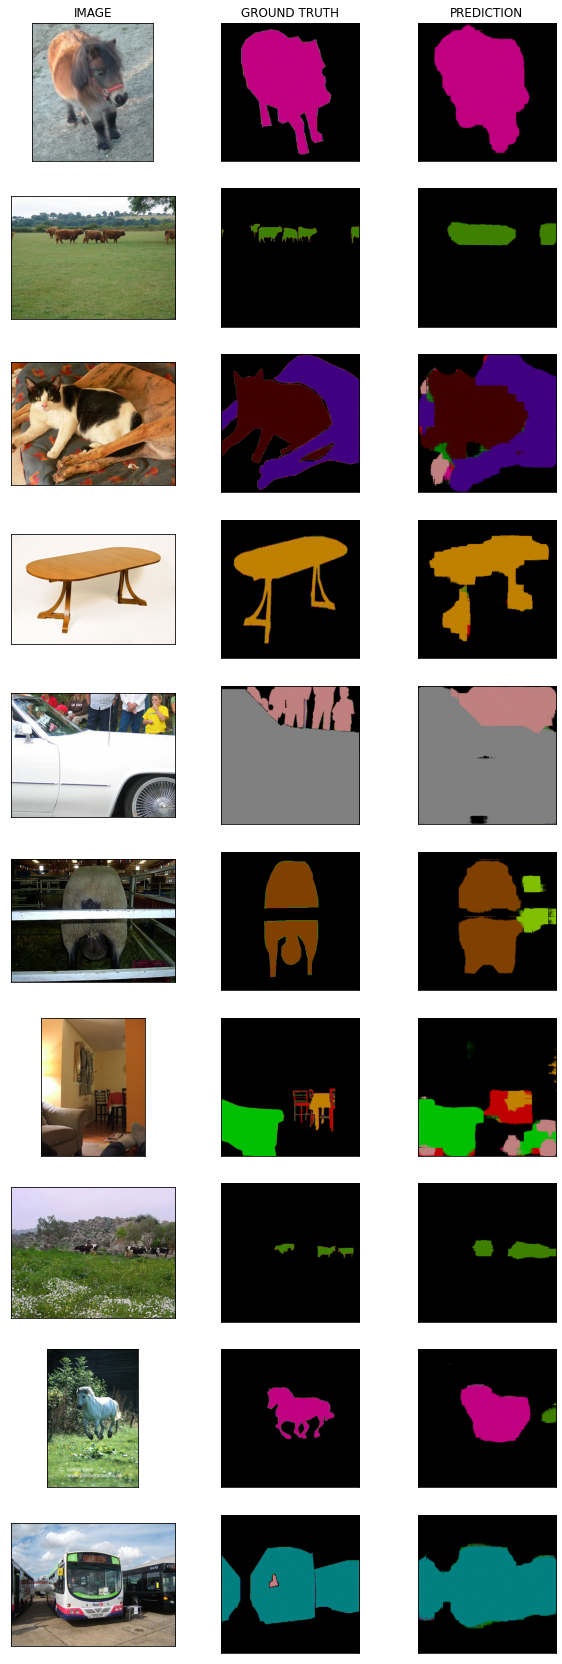

In [24]:
plot_seg_results(images, ground_truths, predictions)